In [1]:
#-*- coding:utf-8 -*-
!pip install selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import time
import urllib.request
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin
from google.colab import drive
drive.mount('/content/drive')
from tqdm.notebook import tqdm
import os

     |████████████████████████████████| 979 kB 5.3 MB/s 
     |████████████████████████████████| 359 kB 45.6 MB/s 
     |████████████████████████████████| 138 kB 53.4 MB/s 
     |████████████████████████████████| 4.0 MB 43.1 MB/s 
     |████████████████████████████████| 55 kB 4.2 MB/s 
     |████████████████████████████████| 58 kB 6.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.9 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://developer.download.nvidi

# 데이터수집(크롤링)

### 폴더생성

In [ ]:
def createFolder(dir):
  try:
    if not os.path.exists(dir):
      os.makedirs(dir)
  except OSError:
    print('Error')

### 네이버크롤링 함수화

In [ ]:
def crawling(search,dir):
  options = webdriver.ChromeOptions()
  options.add_argument('--headless')        # Head-less 설정
  options.add_argument('--no-sandbox')
  options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome('chromedriver', options=options)
  driver.get("https://search.naver.com/search.naver?where=image&sm=tab_jum")
  elem = driver.find_element_by_name("query")
  name = search # 검색할 검색어 입력
  elem.send_keys(name)
  elem.send_keys(Keys.RETURN)

  SCROLL_PAUSE_TIME = 2
  # Get scroll height
  last_height = driver.execute_script("return document.body.scrollHeight")
  while True:
      # Scroll down to bottom
      driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
      # Wait to load page
      time.sleep(SCROLL_PAUSE_TIME)
      # Calculate new scroll height and compare with last scroll heigaht
      new_height = driver.execute_script("return document.body.scrollHeight")
      if new_height == last_height:
          try:
              driver.find_element_by_css_selector(".mye4qd").click()
          except:
              break
      last_height = new_height

  images = driver.find_elements_by_css_selector("._image._listImage")
  count = 1
  for image in images:
      image.click()
      imgUrl = driver.find_element_by_xpath("/html/body/div[3]/div[2]/div/div[1]/section[2]/div/div[2]/div/div/div[1]/div[1]/div/div/div[1]/div[1]/img").get_attribute("src")
      opener=urllib.request.build_opener()
      opener.addheaders=[('User-Agent','Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36')] # PC의 User-Agent값 입력
      urllib.request.install_opener(opener)
      urllib.request.urlretrieve(imgUrl, dir+'/'+str(count) + ".jpg") # name 이름 폴더 생성후 해당 폴더에 이미지 저장
      count = count + 1

  driver.close()

### 검색할 대상 전체 크롤링

In [ ]:
search_list = ['코커스파니엘','푸들','그레이하운드','말티즈','퍼그','비숑','진돗개','삽살개','시베리안허스키','말라뮤트','닥스훈트','코기','리트리버','포메']
common_dir = '/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/'
dir_list = [common_dir+search for search in search_list]
for dir,search in zip(dir_list,search_list):
  createFolder(dir)
  crawling(search,dir)

# 데이터 정제(데이터 전처리)
- zero-centring
- float데이터형 int로 변환
- labeling 0~13 총 14개 유형데이터
- resize하기 , 크기 Resnet50 Default Before (224,224,3) = 150,000 ->  After(180,180,3) -> 100,000
- pickle파일로 저장

### 데이터 불러오기

In [2]:
data_path = '/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)'
os.listdir(data_path)

['image.pickle',
 'label.pickle',
 'final_model.h5',
 'real_final_model.h5',
 'final_model(V2).h5',
 'real_final_model(V2).h5',
 'final_model(V3).h5',
 'real_final_model(V3).h5']

### 데이터 자동라벨링

In [ ]:
label_list = {}
for i,search in enumerate(search_list):
  label_list[search] = i
label_list

{'그레이하운드': 2,
 '닥스훈트': 10,
 '리트리버': 12,
 '말라뮤트': 9,
 '말티즈': 3,
 '비숑': 5,
 '삽살개': 7,
 '시베리안허스키': 8,
 '진돗개': 6,
 '코기': 11,
 '코커스파니엘': 0,
 '퍼그': 4,
 '포메': 13,
 '푸들': 1}

### python 딕셔너리 한글오류로 임시방편으로 유니코드로 값저장

In [ ]:
label_list = {}
i = 0
for name in os.listdir(data_path):
  name = str(name.encode('utf-8'))
  label_list[name]=i
  i+=1
label_list

{"b'\\xe1\\x84\\x80\\xe1\\x85\\xb3\\xe1\\x84\\x85\\xe1\\x85\\xa6\\xe1\\x84\\x8b\\xe1\\x85\\xb5\\xe1\\x84\\x92\\xe1\\x85\\xa1\\xe1\\x84\\x8b\\xe1\\x85\\xae\\xe1\\x86\\xab\\xe1\\x84\\x83\\xe1\\x85\\xb3'": 3,
 "b'\\xe1\\x84\\x83\\xe1\\x85\\xa1\\xe1\\x86\\xa8\\xe1\\x84\\x89\\xe1\\x85\\xb3\\xe1\\x84\\x92\\xe1\\x85\\xae\\xe1\\x86\\xab\\xe1\\x84\\x90\\xe1\\x85\\xb3'": 10,
 "b'\\xe1\\x84\\x85\\xe1\\x85\\xb5\\xe1\\x84\\x90\\xe1\\x85\\xb3\\xe1\\x84\\x85\\xe1\\x85\\xb5\\xe1\\x84\\x87\\xe1\\x85\\xa5'": 12,
 "b'\\xe1\\x84\\x86\\xe1\\x85\\xa1\\xe1\\x86\\xaf\\xe1\\x84\\x85\\xe1\\x85\\xa1\\xe1\\x84\\x86\\xe1\\x85\\xb2\\xe1\\x84\\x90\\xe1\\x85\\xb3'": 9,
 "b'\\xe1\\x84\\x86\\xe1\\x85\\xa1\\xe1\\x86\\xaf\\xe1\\x84\\x90\\xe1\\x85\\xb5\\xe1\\x84\\x8c\\xe1\\x85\\xb3'": 0,
 "b'\\xe1\\x84\\x87\\xe1\\x85\\xb5\\xe1\\x84\\x89\\xe1\\x85\\xad\\xe1\\x86\\xbc'": 5,
 "b'\\xe1\\x84\\x89\\xe1\\x85\\xa1\\xe1\\x86\\xb8\\xe1\\x84\\x89\\xe1\\x85\\xa1\\xe1\\x86\\xaf\\xe1\\x84\\x80\\xe1\\x85\\xa2'": 7,
 "b'\\xe1\\x84\\x89\\

In [ ]:
dataset = {}
dir = os.listdir(data_path)
# 이미지와 라벨 리스트에 담기
for label in dir:
  sub_path = '/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/'+label+'/'
  label = str(label.encode('utf-8'))
  label = str(label_list[label])
  dataset[label] = []
  for filename in os.listdir(sub_path):
    dataset[label].append(sub_path+filename)
dataset

### 데이터 resize

In [ ]:
x_datasets, y_datasets = [], []
temp = '말티즈'
for label, filenames in dataset.items():
  for filename in tqdm(filenames):
    # img를 array 형태로 변경
    image = cv2.imread(filename)
    resize = lambda x: tf.image.resize(x, (180, 180))
    image = resize(image)
    x_datasets.append(image)
    y_datasets.append(label)

  0%|          | 0/541 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

  0%|          | 0/541 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

  0%|          | 0/531 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/535 [00:00<?, ?it/s]

  0%|          | 0/531 [00:00<?, ?it/s]

  0%|          | 0/529 [00:00<?, ?it/s]

  0%|          | 0/538 [00:00<?, ?it/s]

  0%|          | 0/533 [00:00<?, ?it/s]

  0%|          | 0/540 [00:00<?, ?it/s]

  0%|          | 0/545 [00:00<?, ?it/s]

### 이미지 데이터와 라벨데이터확인

In [ ]:
x_datasets = np.array(x_datasets)
x_datasets.shape

(7500, 180, 180, 3)

In [ ]:
y_datasets = np.array(y_datasets)
y_datasets.shape

(7500,)

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import pickle

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### 사진 테스트

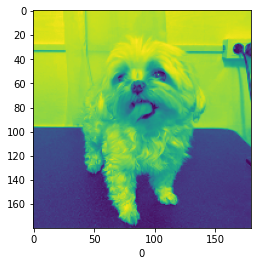

In [ ]:
plt.imshow(x_datasets[0][:,:,0])
plt.xlabel(y_datasets[0])
plt.show()

### 전처리파일저장

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/image.pickle', 'wb') as f:
    pickle.dump(x_datasets, f)
with open('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/label.pickle', 'wb') as f:
    pickle.dump(y_datasets, f)

# 모델학습하기(Version1)
- 사용모델 : Resnet50
- 학습방법 : 전이학습을통한 fine-tunning 기법 학습
- 최고정확도 : 0.8667(성능향상의 존재함)


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import datasets, layers, models

from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D
from tensorflow.keras import Input
from tensorflow.keras.layers import Dropout, BatchNormalization

import matplotlib.pyplot as plt

### 전처리 데이터 불러오기

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/image.pickle','rb') as f:
  data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/label.pickle','rb') as f:
  label = pickle.load(f)

In [ ]:
data.shape,label.shape

((7500, 180, 180, 3), (7500,))

### train, test 셋 분리

In [ ]:
from sklearn.model_selection import train_test_split
train_data, test_data , train_label,test_label = train_test_split(data,label, random_state=7777,test_size=0.2,stratify=label)

In [ ]:
train_data.shape,test_data.shape

((6000, 180, 180, 3), (1500, 180, 180, 3))

### zero centering 과 Data int 화진행

In [ ]:
def preprocess(image,mean):
    image -= mean
    return np.array(image)

In [ ]:
import numpy as np
mean = np.mean(train_data, axis=0)

In [ ]:
train = preprocess(train_data,mean)
test = preprocess(test_data,mean)

In [ ]:
train = train.astype(np.int32)
test = test.astype(np.int32)

In [ ]:
train_label = train_label.astype(np.int32)
test_label = test_label.astype(np.int32)

### 딥러닝 모델정의(하위층+분류층 학습) Dropout(0.5) 2번 사용한 모델


In [ ]:
back_model = ResNet50(include_top=False, input_shape = (180,180 ,3), weights = 'imagenet')
back_model.trainable = False

for layer in back_model.layers[-12:]:
  layer.trainable = True

inputs = tf.keras.Input(shape=(180,180,3))

x = back_model(inputs, training=False)

# FC층 학습
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(14,activation='softmax')(x)

model = tf.keras.Model(inputs,outputs)
model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


### 딥러닝 모델 훈련

In [ ]:
model.fit(train,train_label, epochs=10,batch_size=128,validation_data=(test,test_label))

Epoch 1/10
47/47 [==============================] - 53s 805ms/step - loss: 2.7767 - accuracy: 0.1472 - val_loss: 1.9000 - val_accuracy: 0.3673
Epoch 2/10
47/47 [==============================] - 32s 693ms/step - loss: 1.9682 - accuracy: 0.3222 - val_loss: 1.2965 - val_accuracy: 0.5913
Epoch 3/10
47/47 [==============================] - 32s 691ms/step - loss: 1.5986 - accuracy: 0.4515 - val_loss: 0.8825 - val_accuracy: 0.7553
Epoch 4/10
47/47 [==============================] - 32s 691ms/step - loss: 1.2867 - accuracy: 0.5643 - val_loss: 0.6913 - val_accuracy: 0.8100
Epoch 5/10
47/47 [==============================] - 32s 691ms/step - loss: 1.1148 - accuracy: 0.6248 - val_loss: 0.6504 - val_accuracy: 0.8247
Epoch 6/10
47/47 [==============================] - 32s 690ms/step - loss: 0.9785 - accuracy: 0.6628 - val_loss: 0.5467 - val_accuracy: 0.8520
Epoch 7/10
47/47 [==============================] - 32s 689ms/step - loss: 0.8421 - accuracy: 0.7078 - val_loss: 0.5341 - val_accuracy: 0.8427

### 모델 저장

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/final_model.h5')

# fine-tunning 모델학습(Version1)
- 최고정확도 : 0.8760

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/final_model.h5')

### fine-tunning 모델학습

In [ ]:
 ## fine-tune
model.trainable = True # bottlenect feature 학습진행한다

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.fit(train, train_label, epochs = 10, validation_data=(test, test_label), batch_size= 128)

Epoch 1/10
47/47 [==============================] - 111s 2s/step - loss: 0.9935 - accuracy: 0.6895 - val_loss: 0.5768 - val_accuracy: 0.8280
Epoch 2/10
47/47 [==============================] - 96s 2s/step - loss: 0.6322 - accuracy: 0.7923 - val_loss: 0.5530 - val_accuracy: 0.8527
Epoch 3/10
47/47 [==============================] - 96s 2s/step - loss: 0.4820 - accuracy: 0.8467 - val_loss: 0.5567 - val_accuracy: 0.8580
Epoch 4/10
47/47 [==============================] - 96s 2s/step - loss: 0.3464 - accuracy: 0.8878 - val_loss: 0.7885 - val_accuracy: 0.8293
Epoch 5/10
47/47 [==============================] - 96s 2s/step - loss: 0.3095 - accuracy: 0.9057 - val_loss: 0.5056 - val_accuracy: 0.8760
Epoch 6/10
47/47 [==============================] - 96s 2s/step - loss: 0.2320 - accuracy: 0.9268 - val_loss: 0.7369 - val_accuracy: 0.8660
Epoch 7/10
47/47 [==============================] - 96s 2s/step - loss: 0.2161 - accuracy: 0.9367 - val_loss: 0.5718 - val_accuracy: 0.8440
Epoch 8/10
47/47 [=

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/real_final_model.h5')

# 모델학습하기(Version2)
- 최고정확도 : 0.8940

In [ ]:
back_model = ResNet50(include_top=False, input_shape = (180,180 ,3), weights = 'imagenet')
back_model.trainable = False

for layer in back_model.layers[-12:]:
  layer.trainable = True

inputs = tf.keras.Input(shape=(180,180,3))

x = back_model(inputs, training=False)

# FC층 학습
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(14,activation='softmax')(x)

model = tf.keras.Model(inputs,outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_4 (Dense)             (None, 128)               9437312   
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 14)                1806      
                                                                 
Total params: 33,026,830
Trainable params: 9,439,118
Non-tr

In [ ]:
model.fit(train,train_label, epochs=10,batch_size=128,validation_data=(test,test_label))

Epoch 1/10
47/47 [==============================] - 39s 720ms/step - loss: 1.6520 - accuracy: 0.5262 - val_loss: 0.5540 - val_accuracy: 0.8153
Epoch 2/10
47/47 [==============================] - 33s 695ms/step - loss: 0.6134 - accuracy: 0.8095 - val_loss: 0.4442 - val_accuracy: 0.8560
Epoch 3/10
47/47 [==============================] - 32s 692ms/step - loss: 0.4269 - accuracy: 0.8613 - val_loss: 0.4356 - val_accuracy: 0.8667
Epoch 4/10
47/47 [==============================] - 32s 692ms/step - loss: 0.3195 - accuracy: 0.8942 - val_loss: 0.4219 - val_accuracy: 0.8700
Epoch 5/10
47/47 [==============================] - 32s 692ms/step - loss: 0.2453 - accuracy: 0.9163 - val_loss: 0.4682 - val_accuracy: 0.8687
Epoch 6/10
47/47 [==============================] - 32s 692ms/step - loss: 0.1808 - accuracy: 0.9387 - val_loss: 0.4465 - val_accuracy: 0.8793
Epoch 7/10
47/47 [==============================] - 32s 693ms/step - loss: 0.1473 - accuracy: 0.9477 - val_loss: 0.4543 - val_accuracy: 0.8820

### 모델저장

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/final_model(V2).h5')

# fine-tunning 모델학습(Version2)
- 최고정확도 : 0.8920

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/final_model(V2).h5')

In [ ]:
 ## fine-tune
model.trainable = True # bottlenect feature 학습진행한다

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.fit(train, train_label, epochs = 10, validation_data=(test, test_label), batch_size= 128)

Epoch 1/10
47/47 [==============================] - 104s 2s/step - loss: 0.4542 - accuracy: 0.8588 - val_loss: 0.5081 - val_accuracy: 0.8520
Epoch 2/10
47/47 [==============================] - 96s 2s/step - loss: 0.2002 - accuracy: 0.9372 - val_loss: 0.4860 - val_accuracy: 0.8753
Epoch 3/10
47/47 [==============================] - 96s 2s/step - loss: 0.1588 - accuracy: 0.9505 - val_loss: 0.4726 - val_accuracy: 0.8653
Epoch 4/10
47/47 [==============================] - 96s 2s/step - loss: 0.1528 - accuracy: 0.9503 - val_loss: 0.4717 - val_accuracy: 0.8727
Epoch 5/10
47/47 [==============================] - 96s 2s/step - loss: 0.1081 - accuracy: 0.9653 - val_loss: 0.4940 - val_accuracy: 0.8807
Epoch 6/10
47/47 [==============================] - 96s 2s/step - loss: 0.0805 - accuracy: 0.9758 - val_loss: 0.5223 - val_accuracy: 0.8780
Epoch 7/10
47/47 [==============================] - 96s 2s/step - loss: 0.0769 - accuracy: 0.9757 - val_loss: 0.4760 - val_accuracy: 0.8813
Epoch 8/10
47/47 [=

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               9437312   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 14)                1806      
                                                                 
Total params: 33,026,830
Trainable params: 32,973,710
Non-t

### 모델저장

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/real_final_model(V2).h5')

# 모델학습하기(Version3)
- 분류층+하위층만 학습하기 일부층 :30층, FC층 변경
- 최고성능 : 0.8920

In [ ]:
back_model = ResNet50(include_top=False, input_shape = (180,180 ,3), weights = 'imagenet')
back_model.trainable = False

for layer in back_model.layers[-30:]:
  layer.trainable = True

inputs = tf.keras.Input(shape=(180,180,3))

x = back_model(inputs, training=False)

# FC층 학습
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(256,activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(14,activation='softmax')(x)

model = tf.keras.Model(inputs,outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 73728)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               18874624  
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 14)                3598      
                                                                 
Total params: 42,465,934
Trainable params: 18,878,222
Non-t

In [ ]:
model.fit(train,train_label, epochs=5,batch_size=128,validation_data=(test,test_label))

Epoch 1/5
47/47 [==============================] - 33s 705ms/step - loss: 0.0429 - accuracy: 0.9852 - val_loss: 0.4898 - val_accuracy: 0.8813
Epoch 2/5
47/47 [==============================] - 33s 703ms/step - loss: 0.0435 - accuracy: 0.9855 - val_loss: 0.4558 - val_accuracy: 0.8900
Epoch 3/5
47/47 [==============================] - 33s 702ms/step - loss: 0.0375 - accuracy: 0.9872 - val_loss: 0.4721 - val_accuracy: 0.8913
Epoch 4/5
47/47 [==============================] - 33s 702ms/step - loss: 0.0395 - accuracy: 0.9878 - val_loss: 0.4865 - val_accuracy: 0.8920
Epoch 5/5
47/47 [==============================] - 33s 701ms/step - loss: 0.0259 - accuracy: 0.9922 - val_loss: 0.4950 - val_accuracy: 0.8887


### 1~10 epoch 결과값
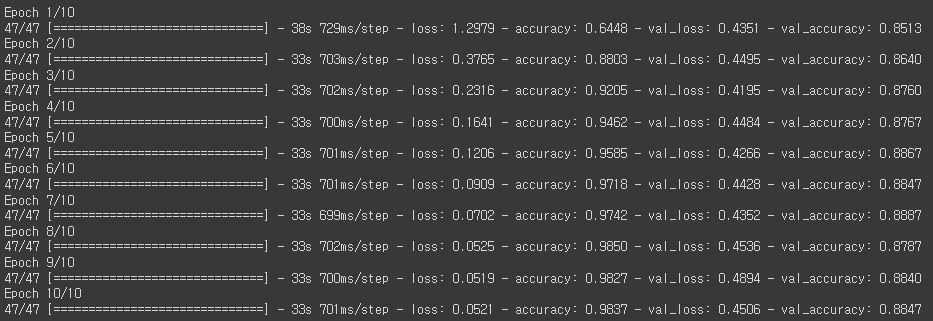

### 11~15 epohc  결과값
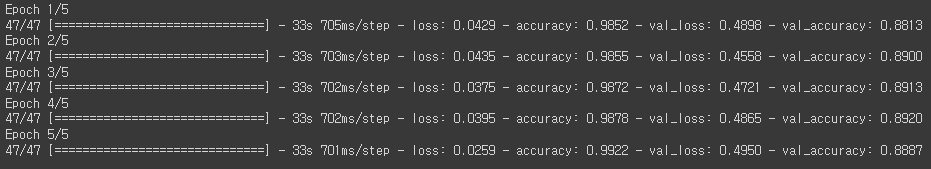

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/final_model(V3).h5')

# fine-tunning 모델학습(Version3)

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/final_model(V3).h5')

In [ ]:
 ## fine-tune
model.trainable = True # bottlenect feature 학습진행한다

model.compile(optimizer = tf.keras.optimizers.Adam( learning_rate= 0.0001),
                loss = 'sparse_categorical_crossentropy',
                metrics=['accuracy'])

model.fit(train, train_label, epochs = 10, validation_data=(test, test_label), batch_size= 128)

Epoch 1/10
47/47 [==============================] - 104s 2s/step - loss: 0.3776 - accuracy: 0.8877 - val_loss: 0.4570 - val_accuracy: 0.8660
Epoch 2/10
47/47 [==============================] - 96s 2s/step - loss: 0.1044 - accuracy: 0.9673 - val_loss: 0.4445 - val_accuracy: 0.8647
Epoch 3/10
47/47 [==============================] - 96s 2s/step - loss: 0.0775 - accuracy: 0.9770 - val_loss: 0.4759 - val_accuracy: 0.8653
Epoch 4/10
47/47 [==============================] - 96s 2s/step - loss: 0.1005 - accuracy: 0.9698 - val_loss: 0.5651 - val_accuracy: 0.8313
Epoch 5/10
47/47 [==============================] - 96s 2s/step - loss: 0.0760 - accuracy: 0.9762 - val_loss: 0.5386 - val_accuracy: 0.8820
Epoch 6/10
47/47 [==============================] - 96s 2s/step - loss: 0.0751 - accuracy: 0.9762 - val_loss: 0.4833 - val_accuracy: 0.8700
Epoch 7/10
47/47 [==============================] - 96s 2s/step - loss: 0.0489 - accuracy: 0.9838 - val_loss: 0.5813 - val_accuracy: 0.8613
Epoch 8/10
47/47 [=

### 모델 저장

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/국비지원수업(K-digital)/프로젝트/강아지품종예측(이미지 인식 프로젝트)/데이터수집(크롤링)/real_final_model(V3).h5')

# 결론
- 모델정확도 89%까지 개선
- 개선할수있는 부분 : 

1)Overfitting방지 -> 데이터양늘리기 Data Augmentation기법, FC층 변경 

2)Dataset 품질개선 -> 잘못된 데이터 삭제
